In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load your cleaned dataset
df = pd.read_csv("Uber_Customer_Support_Tickets_Cleaned.csv")
df["Created_At"] = pd.to_datetime(df["Created_At"], errors="coerce")
df = df.dropna(subset=["Created_At"]).sort_values("Created_At")

In [29]:
# Round Created_At to date only (no time)
df["Date"] = pd.to_datetime(df["Created_At"]).dt.date

# Aggregate daily
df_daily = df.groupby("Date").agg(
    Daily_Ticket_Count=("Ticket_ID", "count"),
    Avg_CSAT=("CSAT_Score", "mean")
).reset_index()

# Prophet expects 'ds' (datetime) not date objects
df_daily["ds"] = pd.to_datetime(df_daily["Date"])
df_daily = df_daily.rename(columns={"Daily_Ticket_Count": "y"})

print(df_daily.head())


         Date   y  Avg_CSAT         ds
0  2025-01-01  18  3.833333 2025-01-01
1  2025-01-02  15  3.466667 2025-01-02
2  2025-01-03  14  4.071429 2025-01-03
3  2025-01-04  13  3.538462 2025-01-04
4  2025-01-05  13  3.615385 2025-01-05


In [30]:
from prophet import Prophet

m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,  # disable long-term seasonality
    daily_seasonality=False
)
m.fit(df_daily[["ds", "y"]])

# Predict on the same period — not the future
future = df_daily[["ds"]]  # no make_future_dataframe() here!
forecast = m.predict(future)


17:15:18 - cmdstanpy - INFO - Chain [1] start processing
17:15:18 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
merged = df_daily.merge(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds")
merged["is_anomaly"] = (merged["y"] > merged["yhat_upper"]) | (merged["y"] < merged["yhat_lower"])

print("Anomalies flagged:", merged["is_anomaly"].sum())
merged[merged["is_anomaly"]].head()


Anomalies flagged: 16


,Date,y,Avg_CSAT,ds,yhat,yhat_lower,yhat_upper,is_anomaly
0,2025-01-01,18,3.833333,2025-01-01,10.525043,6.046302,14.862187,True
7,2025-01-08,15,3.733333,2025-01-08,10.503571,6.313006,14.553843,True
10,2025-01-11,5,3.400000,2025-01-11,10.042564,5.917069,14.535894,True
16,2025-01-17,16,4.187500,2025-01-17,11.019856,6.844383,15.555926,True
23,2025-01-24,17,3.882353,2025-01-24,10.998384,6.967478,15.394287,True


In [19]:
#plot

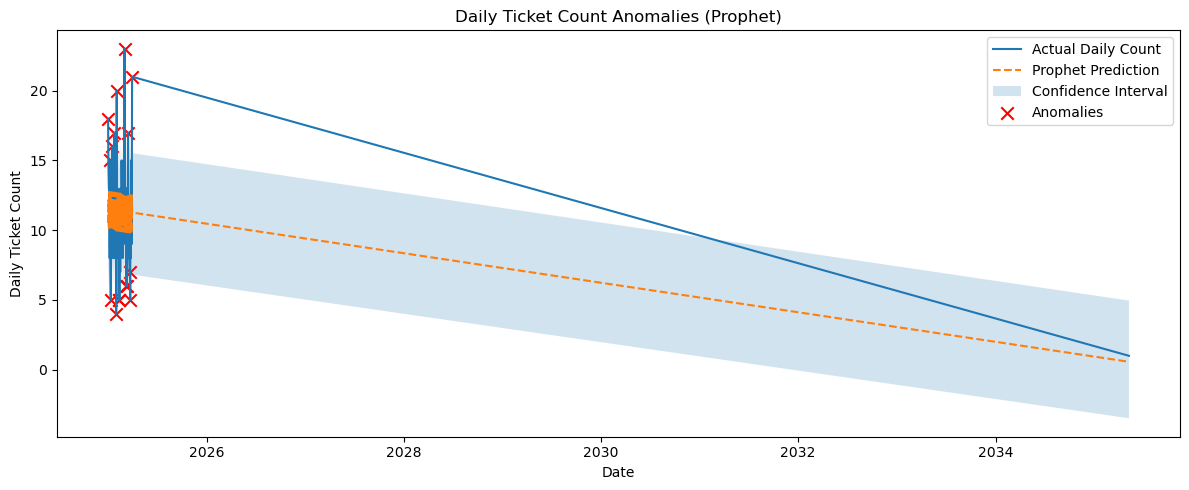

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(merged["ds"], merged["y"], label="Actual Daily Count")
plt.plot(merged["ds"], merged["yhat"], linestyle="--", label="Prophet Prediction")
plt.fill_between(merged["ds"], merged["yhat_lower"], merged["yhat_upper"], alpha=0.2, label="Confidence Interval")

anomalies = merged[merged["is_anomaly"]]
plt.scatter(anomalies["ds"], anomalies["y"], color="red", marker="x", s=80, label="Anomalies")

plt.xlabel("Date")
plt.ylabel("Daily Ticket Count")
plt.title("Daily Ticket Count Anomalies (Prophet)")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
#identify anomalies